

***

## COVID-19 Tweet Sentiment Prediction  

Given *tweets about the COVID-19 pandemic*, let's try to predict the **sentiment** of a given tweet.  
  
We will use a TensorFlow RNN to make our predictions.

# Let's GO

In [84]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
import re
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow as tf

In [42]:
import spacy

nlp = spacy.load("en_core_web_sm")

In [2]:
train_df = pd.read_csv("Corona_NLP_train.csv",encoding='latin-1')
test_df = pd.read_csv("Corona_NLP_test.csv",encoding='latin-1')

In [3]:
train_df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...,...,...,...,...
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral
41153,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative
41154,44953,89905,NaN,14-04-2020,You know itÂs getting tough when @KameronWild...,Positive
41155,44954,89906,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral


In [4]:
test_df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral
...,...,...,...,...,...,...
3793,3794,48746,Israel ??,16-03-2020,Meanwhile In A Supermarket in Israel -- People...,Positive
3794,3795,48747,"Farmington, NM",16-03-2020,Did you panic buy a lot of non-perishable item...,Negative
3795,3796,48748,"Haverford, PA",16-03-2020,Asst Prof of Economics @cconces was on @NBCPhi...,Neutral
3796,3797,48749,NaN,16-03-2020,Gov need to do somethings instead of biar je r...,Extremely Negative


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       3798 non-null   int64 
 1   ScreenName     3798 non-null   int64 
 2   Location       2964 non-null   object
 3   TweetAt        3798 non-null   object
 4   OriginalTweet  3798 non-null   object
 5   Sentiment      3798 non-null   object
dtypes: int64(2), object(4)
memory usage: 178.2+ KB


# EDA

In [90]:
time = train_df.groupby(['TweetAt']).size()
fig = px.line(train_df, 
              x=time.index, 
              y=time.values, 
              title = 'Date of tweets',
              template='simple_white')

fig.update_layout(
font=dict(size=15,family="Times New Roman"),)

fig.show()

<AxesSubplot:xlabel='Sentiment', ylabel='count'>

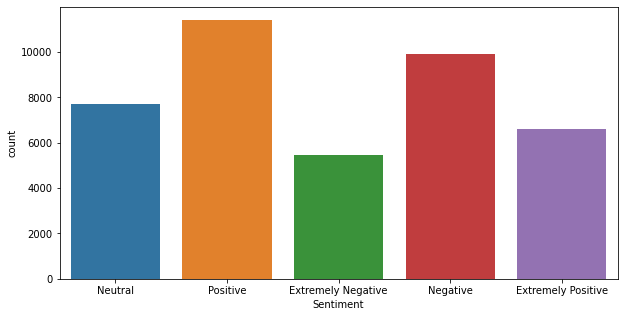

In [62]:
plt.figure(figsize=(10,5))
sns.countplot(x=train_df["Sentiment"])

### There's 5 sentiments in the dataset: Positive, Negative, Neutral, Extremely Postive and Extremely Negative.Each Positive and Negative account for 27.8% and 24.1%.

In [80]:
location = train_df['Location'].value_counts().nlargest(n=10)
fig = px.bar(y=location.values,
       x=location.index,
       orientation='v',
       color=location.index,
       text=location.values,
       color_discrete_sequence= px.colors.qualitative.Bold)
fig.show()

### We can notice that UK and US ranked top 2 locations of covid-19 tweets, and India & Australia ranked the next.

In [81]:
positive = train_df.loc[np.where(train_df['Sentiment'] == 'Positive')].reset_index()
negative = train_df.loc[np.where(train_df['Sentiment'] == 'Negative')].reset_index()
neutral = train_df.loc[np.where(train_df['Sentiment'] == 'Neutral')].reset_index()
extremely_positive = train_df.loc[np.where(train_df['Sentiment'] == 'Extremely Positive')].reset_index()
extremely_negative = train_df.loc[np.where(train_df['Sentiment'] == 'Extremely Negative')].reset_index()

In [82]:
train_df['Length'] = train_df['OriginalTweet'].apply(len)
hist_data = [extremely_positive['Length'],positive['Length'],neutral['Length'],
             negative['Length'],extremely_negative['Length']]

group_labels = ['extremely_positive','positive','neutral','negative','extremely_negative']

colors = ['navy', 'blue', 'lightblue','lightsalmon','red']

In [86]:
fig = ff.create_distplot(hist_data, group_labels, show_hist=False, colors = colors)
fig.show()

### It is obvious that sentiment of 'extremely negative' and 'extremely positive' mostly distributed at high length, and negative & positive the next.

# Preprocessing

In [7]:
train_inputs = train_df['OriginalTweet'].copy()
test_inputs = test_df['OriginalTweet'].copy()

train_labels = train_df['Sentiment'].copy()
test_labels = test_df['Sentiment'].copy()

In [8]:
sentiment_encoding = {
    'Extremely Negative': 0,
    'Negative': 0,
    'Neutral': 1,
    'Positive': 2,
    'Extremely Positive': 2
}

train_labels = train_labels.replace(sentiment_encoding)
test_labels = test_labels.replace(sentiment_encoding)

In [9]:
train_inputs

0        @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...
1        advice Talk to your neighbours family to excha...
2        Coronavirus Australia: Woolworths to give elde...
3        My food stock is not the only one which is emp...
4        Me, ready to go at supermarket during the #COV...
                               ...                        
41152    Airline pilots offering to stock supermarket s...
41153    Response to complaint not provided citing COVI...
41154    You know itÂs getting tough when @KameronWild...
41155    Is it wrong that the smell of hand sanitizer i...
41156    @TartiiCat Well new/used Rift S are going for ...
Name: OriginalTweet, Length: 41157, dtype: object

In [43]:
#stop_words = set(stopwords.words('english'))


In [48]:


def process_tweet(tweet):
    
    # remove urls
    tweet = re.sub(r'http\S+', ' ', tweet)
    
    # remove html tags
    tweet = re.sub(r'<.*?>', ' ', tweet)
    
    # remove digits
    tweet = re.sub(r'\d+', ' ', tweet)
    
    # remove hashtags
    tweet = re.sub(r'#\w+', ' ', tweet)
    
    # remove mentions
    tweet = re.sub(r'@\w+', ' ', tweet)
    
    #removing stop words
    tweet = tweet.split()
    tweet = " ".join([word for word in tweet if not word.is_stop])
    
    return tweet

In [ ]:
train_inputs = train_inputs.apply(process_tweet)
test_inputs = test_inputs.apply(process_tweet)

In [30]:
train_inputs

0                                                  and and
1        advice Talk to your neighbours family to excha...
2        Coronavirus Australia: Woolworths to give elde...
3        My food stock is not the only one which is emp...
4        Me, ready to go at supermarket during the outb...
                               ...                        
41152    Airline pilots offering to stock supermarket s...
41153    Response to complaint not provided citing COVI...
41154    You know itÂs getting tough when is rationing...
41155    Is it wrong that the smell of hand sanitizer i...
41156    Well new/used Rift S are going for $ . on Amaz...
Name: OriginalTweet, Length: 41157, dtype: object

In [31]:
max_seq_length = np.max(train_inputs.apply(lambda tweet: len(tweet)))

In [32]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_inputs)

vocab_length = len(tokenizer.word_index) + 1


train_inputs = tokenizer.texts_to_sequences(train_inputs)
test_inputs = tokenizer.texts_to_sequences(test_inputs)
# Use Post Padding 
train_inputs = pad_sequences(train_inputs, maxlen=max_seq_length, padding='post')
test_inputs = pad_sequences(test_inputs, maxlen=max_seq_length, padding='post')

In [40]:
print("Vocab length:", vocab_length)
print("Max sequence length:", max_seq_length)

Vocab length: 36127
Max sequence length: 294


# Modeling

In [34]:
train_inputs.shape

(41157, 294)

In [35]:
embedding_dim = 16    #16 features


inputs = tf.keras.Input(shape=(max_seq_length,), name='input_layer')

embedding = tf.keras.layers.Embedding(
    input_dim=vocab_length,
    output_dim=embedding_dim,
    input_length=max_seq_length,
    name='word_embedding'
)(inputs)

gru_layer = tf.keras.layers.Bidirectional(
    tf.keras.layers.GRU(units=256, return_sequences=True, name='gru_layer'),
    name='bidirectional_layer'
)(embedding)

max_pooling = tf.keras.layers.GlobalMaxPool1D(name='max_pooling')(gru_layer)

dropout_1 = tf.keras.layers.Dropout(0.4, name='dropout_1')(max_pooling)

dense = tf.keras.layers.Dense(64, activation='relu', name='dense')(dropout_1)

dropout_2 = tf.keras.layers.Dropout(0.4, name='dropout_2')(dense)

outputs = tf.keras.layers.Dense(3, activation='softmax', name='output_layer')(dropout_2)


model = tf.keras.Model(inputs=inputs, outputs=outputs)

print(model.summary())

tf.keras.utils.plot_model(model)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 294)]             0         
                                                                 
 word_embedding (Embedding)  (None, 294, 16)           578032    
                                                                 
 bidirectional_layer (Bidire  (None, 294, 512)         420864    
 ctional)                                                        
                                                                 
 max_pooling (GlobalMaxPooli  (None, 512)              0         
 ng1D)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense (Dense)               (None, 64)                32832 

# Training

In [36]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


batch_size = 32
epochs = 2

history = model.fit(
    train_inputs,
    train_labels,
    validation_split=0.12,
    batch_size=batch_size,
    epochs=epochs,
    verbose=2
)

Epoch 1/2
1132/1132 - 1935s - loss: 0.6281 - accuracy: 0.7363 - val_loss: 0.3988 - val_accuracy: 0.8652 - 1935s/epoch - 2s/step
Epoch 2/2
1132/1132 - 1896s - loss: 0.3025 - accuracy: 0.8985 - val_loss: 0.3295 - val_accuracy: 0.8878 - 1896s/epoch - 2s/step


# Results

In [37]:
fig = px.line(
    history.history,
    y=['loss', 'val_loss'],
    labels={'index': "epoch", 'value': "loss"}
)

fig.show()

In [38]:
model.evaluate(test_inputs, test_labels)

119/119 [==============================] - 18s 152ms/step - loss: 0.3489 - accuracy: 0.8789


[0.3488548994064331, 0.8788836002349854]

# Conclusion  

I have used basic data preparation libraries like Pandas, Numpy,Plotly,SNS and Matplotlib. Used Regex,Spacy and Keras preprocessing tokenizer for text cleaning and preprocessing. Applied sequence processing models like Bidirectional GRU,
GlobalMaxPooling for down sampling. Got accuracy of 87 Percent 

***

